In [2]:
import os
import sys
import requests
import urllib
import zipfile
import glob
import datetime
from datetime import date

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colors as colors
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.offline as offline
import plotly.figure_factory as ff
import numpy as np
import seaborn as sns
import warnings
import networkx as nx
#import osmnx as ox   # Error

# US COVID-19 Case Data Visualisation
## Procedure 1: US States and Counties GeoDataFrame (EPSG: 2163)
### US State

In [3]:
# Read US States Boundary Shapefile
us_states_gdf = gpd.read_file('Data/input/us_state/cb_2018_us_state_5m.shp')

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_states_gdf.to_crs(epsg=2163, inplace=True)

In [4]:
# Adding a column 'coords' for later use (labeling each State)
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
us_states_gdf['coords'] = us_states_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
us_states_gdf['coords'] = [coords[0] for coords in us_states_gdf['coords']]

### US County

In [5]:
# Read US Counties Boundary Shapefile
us_counties_gdf = gpd.read_file('Data/input/us_counties/cb_2018_us_county_5m.shp')

# Adding a 'FULLFP' column that concatenates 'STATEFP' and 'COUNTYFP'
us_counties_gdf['FULLFP'] = us_counties_gdf['STATEFP'] + us_counties_gdf['COUNTYFP']

# Converting the CRS to US National Atlas Equal Area Projection (EPSG: 2163)
us_counties_gdf.to_crs(epsg=2163, inplace=True)

In [6]:
# Read US State Name, FIPS, and Postcode csv file 
fips_csv_dir = 'Data/input/us_state_fips/us-state-ansi-fips.csv'
fips_df = pd.read_csv(fips_csv_dir, dtype={' fips':object})

In [7]:
# Rename columns
fips_df.rename(columns=
    {' fips': 'fips',
    ' stusps': 'postcode',},
    inplace=True)

In [8]:
# Attribute Joins - Merging `us_counties_gdf` and `fips_df` on `'STATEFP'` and `'fips'`
merged_df = pd.merge(
    left=us_counties_gdf, 
    right=fips_df, 
    how='left', 
    left_on='STATEFP', 
    right_on='fips'
)

In [9]:
# Remove (drop) 'fips' column
merged_df = merged_df.drop(['fips'], axis=1)

In [10]:
# Make us_gdf a GeoDataFrame of merged_df
us_counties_gdf = gpd.GeoDataFrame(merged_df,
                                   crs={'init': 'epsg:2163'},
                                   geometry=merged_df['geometry'])

## Procedure 2: US COVID-19 Cases/Deaths/Testing DataFrame
### [New York Times US Counties Data](https://github.com/nytimes/covid-19-data)
### [Johns Hopkins Uni & Med US County](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)
### [New York City Data](https://github.com/thecityny/covid-19-nyc-data)

In [87]:
# Read NYTimes COVID-19 US Counties Data
nytimes_counties_df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
                                  dtype={'fips':object}
                                 )

In [88]:
# Changing the 'date' dtype from object to datetime
nytimes_counties_df['date']=pd.to_datetime(nytimes_counties_df['date'])

# There are missing 'fips' values that will cause trouble later on
#nytimes_counties_df['fips'].fillna(0)

In [103]:
nytimes_counties_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


# PROBLEM: There are unknown counties with NaN fips
### Possible Solution: Use the JHU's data instead of NYTimes (Ask how to use the data where each date is a column head)

In [108]:
null_fips_df = nytimes_counties_df[nytimes_counties_df['fips'].isnull()]
null_fips_df['state'].unique()

array(['New York', 'Rhode Island', 'New Jersey', 'Puerto Rico',
       'Virgin Islands', 'Guam', 'Maine', 'Massachusetts', 'Louisiana',
       'Kentucky', 'Nevada', 'Tennessee', 'Arkansas', 'Georgia',
       'Missouri', 'Minnesota', 'California', 'Colorado', 'Florida',
       'Hawaii', 'Illinois', 'Vermont', 'Idaho', 'Michigan', 'Ohio',
       'Utah', 'Mississippi', 'Northern Mariana Islands', 'Nebraska',
       'Connecticut', 'Indiana', 'Alaska', 'Arizona', 'New Mexico',
       'Pennsylvania', 'Virginia', 'New Hampshire', 'South Dakota',
       'Washington', 'Delaware', 'Kansas', 'North Dakota', 'Maryland',
       'Iowa'], dtype=object)

In [112]:
null_fips_df[null_fips_df['state']=='New York']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
565,2020-03-05,New York City,New York,NaN,4,0
...,...,...,...,...,...,...
102792,2020-04-30,New York City,New York,NaN,167489,12514
105654,2020-05-01,New York City,New York,NaN,169701,12700
108522,2020-05-02,New York City,New York,NaN,172364,12895
111396,2020-05-03,New York City,New York,NaN,174341,13064


In [75]:
# Creating a DataFrame for plotting charts (Set 'date' as the index)
nytimes_counties_plot_df = nytimes_counties_df.copy()
nytimes_counties_plot_df.set_index('date', inplace=True)

### [COVID Tracking Project Latest US & States Current Data](https://covidtracking.com/api)

In [14]:
# Read COVID Tracking Project US COVID-19 Current Data
covtrack_us_now_df = pd.read_json('https://covidtracking.com/api/v1/us/current.json')[['positive', 'death', 'total']]

In [15]:
# Read COVID Tracking Project US States COVID-19 Current Data
covtrack_states_now_df = pd.read_json('https://covidtracking.com/api/v1/states/current.json', dtype={'fips':object})[
    ['state', 'fips', 'positive', 'death', 'total']
]

### [COVID Tracking Project US Accumulative Data](https://covidtracking.com/api)

In [16]:
# Read COVID Tracking Project US COVID-19 Accumulative Data
covtrack_us_hist_df = pd.read_json('https://covidtracking.com/api/v1/us/daily.json', dtype={'fips':object})[
    ['date','positive', 'death', 'total']
]

In [17]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_us_hist_df['datetime']=pd.to_datetime(covtrack_us_hist_df['datetime'])

In [18]:
# Creating a DataFrame for plotting charts (Set 'datetime' as the index)
covtrack_us_hist_plot_df = covtrack_us_hist_df[['datetime', 'positive', 'death', 'total']].copy()
covtrack_us_hist_plot_df.set_index('datetime', inplace=True)

### [COVID Tracking Project States Accumulative Data](https://covidtracking.com/api)

In [19]:
# Read COVID Tracking Project US States COVID-19 Accumulative Data
covtrack_states_hist_df = pd.read_json('https://covidtracking.com/api/v1/states/daily.json', dtype={'fips':object})[
    ['date', 'state', 'fips', 'positive', 'death', 'total']
]

In [20]:
# Creating a new column, 'datetime' that converts 'date' from dtype: int to the Dtype: str of datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['date'].astype(str), format='%Y-%m-%d')

# Converting the Dtype to datetime
covtrack_states_hist_df['datetime']=pd.to_datetime(covtrack_states_hist_df['datetime'])

In [21]:
# # Creating a DataFrame for plotting charts (Set 'datetime' as the index)
covtrack_states_hist_plot_df = covtrack_states_hist_df[['datetime', 'state', 'fips', 'positive', 'death', 'total']].copy()
covtrack_states_hist_plot_df.set_index('datetime', inplace=True)

## Procedure 3: Merge US COVID-19 DataFrame with GeoDataFrame `us_cov19_counties_gdf` and `us_cov19_states_gdf`
### `nytimes_counties_df`

In [22]:
# Merge NYTimes US Counties COVID-19 Data with us_counties_gdf
us_cov19_counties_df = pd.merge(
    nytimes_counties_df,
    us_counties_gdf[['FULLFP', 'STATEFP', 'COUNTYFP', 'geometry', 'postcode']],
    left_on='fips',
    right_on='FULLFP',
    how='left',
)

In [23]:
us_cov19_counties_gdf = gpd.GeoDataFrame(us_cov19_counties_df, 
                                         crs={'init': 'epsg:2163'},
                                         geometry='geometry')

In [24]:
us_cov19_counties_gdf = us_cov19_counties_gdf.drop(['FULLFP'], axis=1)

# <font color = 'orangered'> This works only sometimes... </font>

In [25]:
us_cov19_counties_plot_gdf = us_cov19_counties_gdf[['date', 'county', 'state', 'postcode', 'fips', 
                                                    'STATEFP', 'COUNTYFP', 'cases', 'deaths', 'geometry']].copy
us_cov19_counties_plot_gdf.set_index('date', inplace=True)

AttributeError: 'function' object has no attribute 'set_index'

### `covtrack_states_now_df`

In [26]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_now_df = pd.merge(
    covtrack_states_now_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [27]:
us_cov19_states_now_gdf = gpd.GeoDataFrame(us_cov19_states_now_df, 
                                           crs={'init': 'epsg:2163'},
                                           geometry='geometry')

In [28]:
us_cov19_states_now_gdf = us_cov19_states_now_gdf.drop(['STATEFP'], axis=1)

### `covtrack_states_hist_df`

In [29]:
# Merge COVID Tracking Project US States COVID-19 Accumulative Data with us_states_gdf
us_cov19_states_df = pd.merge(
    covtrack_states_hist_df,
    us_states_gdf[['STATEFP', 'NAME', 'coords', 'geometry']],
    left_on='fips',
    right_on='STATEFP',
    how='left',
)

In [30]:
us_cov19_states_gdf = gpd.GeoDataFrame(us_cov19_states_df, 
                                       crs={'init': 'epsg:2163'},
                                       geometry='geometry')

In [31]:
us_cov19_states_gdf = us_cov19_states_gdf.drop(['STATEFP'], axis=1)

In [32]:
# Creating a DataFrame for plotting charts (Set 'datetime' as the index)
us_cov19_states_plot_gdf = us_cov19_states_gdf[['datetime', 'date', 'NAME', 'state', 'fips', 'positive', 'death', 'total', 'coords', 'geometry']].copy()
us_cov19_states_plot_gdf.set_index('datetime', inplace=True)

## Procedure 4: US COVID-19 Data Visualisation
### US History Chart `covtrack_us_hist_df`

# <font color = 'orangered'> QUESTION 2: How do I set the x-axis label (date) to show in `%b %d` format by monthly?? </font>

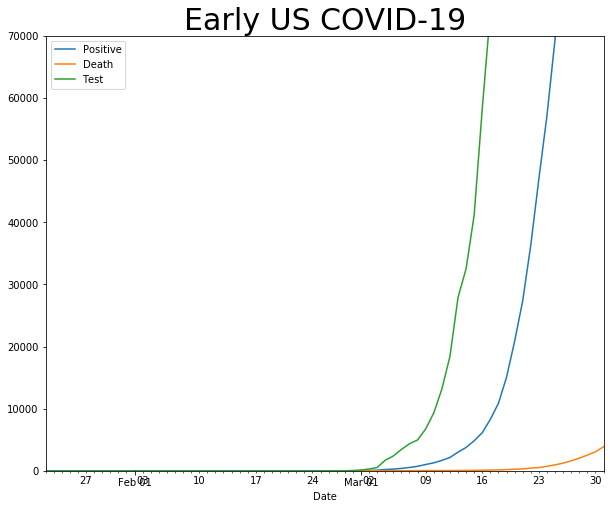

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))

covtrack_us_hist_plot_df.plot(
    ax=ax,
    #x='datetime',
    y=['positive', 'death', 'total'],
    xlim=('2020-01-22', '2020-03-31'),
    ylim=(0, 70000),
    figsize=(10, 8),
);

# x-axis label
plt.xlabel('Date')

# Rename legend
ax.legend(['Positive', 'Death', 'Test'])

# set ticks every month
ax.xaxis.set_major_locator(mdates.MonthLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title('Early US COVID-19', fontdict={'size':30});

### US States Confirmed Cases `us_cov19_states_now_gdf`
# <font color = 'red'> QUESTION 3: How do I change the pre-set legend values?  BoxPlot scheme is good but I just want the numbers to be prettier like 20,000 instead of 20,482.25. </font>

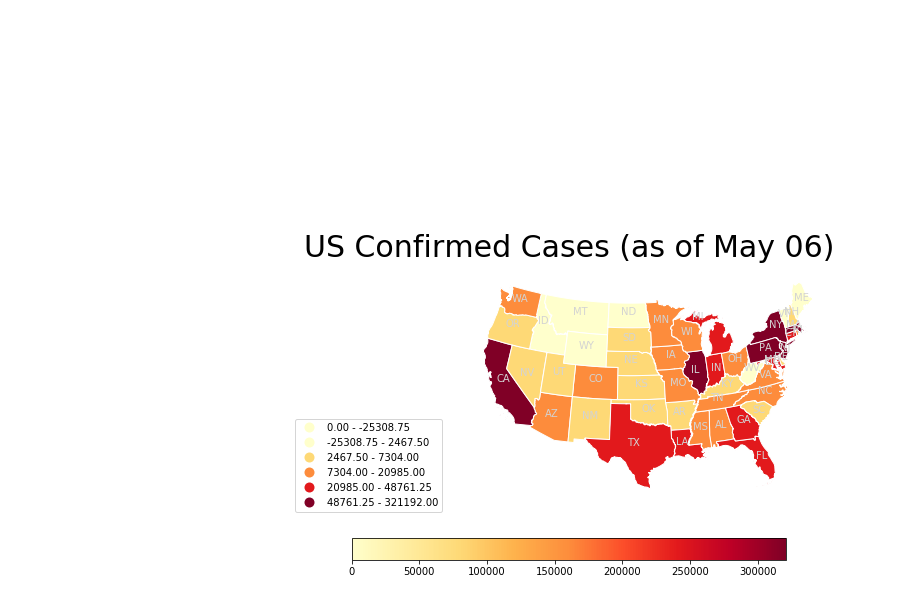

In [271]:
# from datetime import date

fig, ax = plt.subplots(figsize=(10,8))

# Normalize the Legend Color and create the legend bar
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
vmin, vmax = us_cov19_states_now_gdf.positive.min(), us_cov19_states_now_gdf.positive.max()
legend_bar = plt.cm.ScalarMappable(
     norm=plt.Normalize(vmin=vmin, vmax=vmax), 
     cmap='YlOrRd')

# Plot
us_cov19_states_now_gdf.plot(
    ax=ax,
    column='positive',
    cmap='YlOrRd',
    #markersize=2,
    edgecolor='white',
    legend=True,
    scheme='BoxPlot', # or Quantile,
    legend_kwds={'loc': 'lower left'},
)

# Title  
today = datetime.datetime.now()
ax.set_title('US Confirmed Cases (as of ' + today.strftime('%b %d') + ')', fontdict={'size':30});

# Add the Color Legend Bar
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.05, shrink=0.8)

# Customizing legend values
# leg = ax.get_legend()
# leg.get_texts()[0].('New label 1')
# leg.get_texts()[1].set_text('New label 2')

# Displaying each State Postcode
for idx, row in us_cov19_states_now_gdf.iterrows():
    plt.annotate(s=row['state'], xy=row['coords'],
                 horizontalalignment='center',
                 #font.family='serif',
                 color='lightgrey',
                 #alpha=0.9,
                 #bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'edgecolor':'lightyellow'}
                )

# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
ax.set_xlim(-4700000, 3000000)
ax.set_ylim(-2500000, 1000000);
# ax.set_ylim(-2500000, 4200000);  # shows alaska

### by US Counties `us_cov19_counties_df` over time

Plotly Choropleth Maps: https://plotly.com/python/choropleth-maps/

Interactive Map 1: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

Interactive Map 2: https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

In [64]:
us_cov19_counties_df.head()

,date,county,state,fips,cases,deaths,FULLFP,STATEFP,COUNTYFP,geometry,postcode
0,2020-01-21,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
1,2020-01-22,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
2,2020-01-23,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA
3,2020-01-24,Cook,Illinois,17031,1,0,17031,17,031,"POLYGON ((965008.651 -256879.590, 966661.997 -...",IL
4,2020-01-24,Snohomish,Washington,53061,1,0,53061,53,061,"MULTIPOLYGON (((-1634037.628 566970.701, -1633...",WA


In [36]:
# import datetime
county_start_date = datetime.datetime(2020, 5, 4)

county_start_df = us_cov19_counties_df[(nytimes_counties_df['date']==county_start_date)]

In [44]:
# color scheme for the map plot (white to red)
county_color_scale = ['#FFEBEE', '#FFCDD2', '#EF9A9A', '#E57373', '#EF5350', 
                      '#F44336', '#E53935', '#D32F2F', '#C62828', '#B71C1C']

# creating a new column that will include the mouse-hovering text for each county
# for col in county_start_df.columns:
#     county_start_df[col] = county_start_df[col].astype(str)

# county_start_df['text'] = county_start_df['county'] + ', ' + county_start_df['postcode'] + '<br>' + \
#                         'Cases: ' + county_start_df['cases'] + '<br>' + \
#                         'Deaths: ' + county_start_df['deaths']

# PROBLEM: Possibly because of the missing `fips` value from `nytimes` data?

In [48]:
#import plotly.figure_factory as ff

#endpts = list(np.linspace(1, 350000, len(county_color_scale)-1))
fips = county_start_df['fips'].tolist()
values = county_start_df['cases'].tolist()

# creating a fig object for plotting
fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=[2500, 7500, 21000, 50000, 350000], # scheme: 'boxplot'
    colorscale=county_color_scale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, 
    round_legend_values=True,
    show_state_data=False,
    show_hover=True,
    asp=2.9,   #Sets the ratio between height and width
    title_text='US COVID-19 Confirmed Cases (latest update: ' + county_start_date.strftime('%b %d') + ')',
    legend_title='Confirmed Cases',
)

fig.layout.template = None
fig.show()
    
# fig = go.Figure(data=go.Choropleth(
#     locations=county_start_df['fips'],  # the column with the county fips
#     z = county_start_df['cases'].astype(float),  # the variable I want to color-code
#     locationmode = 'USA-states',
#     colorscale = county_color_scale,
#     autocolorscale = False,
#     text = county_start_df['text'], # hover text
#     marker_line_color = 'white'     # for the lines separating states
#     marker_linewidth = 2,    
#     colorbar_title = 'COVID-19 Confirmed Cases'
# ))

TypeError: '<' not supported between instances of 'float' and 'str'

### by US States `covtrack_state_hist_df` or `us_cov19_states_gdf` 
Interactive Map 2: https://amaral.northwestern.edu/blog/step-step-how-plot-map-slider-represent-time-evolu

In [97]:
us_cov19_states_df.shape

(3377, 11)

In [98]:
# import datetime
state_start_date = datetime.datetime(2020, 1, 22)

state_start_df = us_cov19_states_df[(us_cov19_states_df['datetime']==state_start_date)]

In [100]:
state_start_df

,date,state,fips,positive,death,total,datetime,STATEFP,NAME,coords,geometry
3376,20200122,WA,53,1.0,NaN,1.0,2020-01-22,53,Washington,"(-1527952.2481166585, 464302.92549199006)","MULTIPOLYGON (((-1634037.628 566970.701, -1633..."


In [112]:
# color scheme for the map plot (white to red)
state_color_scale = [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'],
                     [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']]

# create an empty list for data object:
data_slider = []

In [113]:
# populate the data object, one dictionary per day that will be displayed with the slider, by iterating over the different years in the data set
for date in us_cov19_states_df.datetime.unique():
    
    # select the date
    each_day_state_df = us_cov19_states_df[(us_cov19_states_df['datetime']==date)]
    
    # creating a new column that will include the mouse-hovering text for each state
    for col in each_day_state_df.columns:
        each_day_state_df[col] = each_day_state_df[col].astype(str)

    # creating the text for mouse-hover for each state
    each_day_state_df['text'] = each_day_state_df['NAME'] + 'Cases: ' + each_day_state_df['positive'] + 'Deaths: ' + each_day_state_df['death'] + 'Tests: ' + each_day_state_df['total']
    
    # create the dictionary with the data for plotting the current date
    data_one_day = [ dict(
                        type='choropleth', # type of map-plot
                        colorscale = state_color_scale,
                        autocolorscale = False,
                        locations = each_day_state_df['state'], # the column with the state post code
                        z = each_day_state_df['positive'].astype(float), # the variable I want to color-code
                        locationmode = 'USA-states',
                        text = each_day_state_df['text'], # hover text
                        marker = dict(     # for the lines separating states
                                    line = dict (
                                              color = 'rgb(255,255,255)', 
                                              width = 2) ),               
                        colorbar = dict(
                                    title = "Confirmed Cases")
                        ) 
                   ]
    
    # add the dictionary to the list of dictionaries for the slider
    data_slider.append(data_one_day)

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dun4g\anaconda3\envs\GIS\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# <font color='red'> QUESTION : How do I make the slider step to be each date? </font>

In [118]:
# Create the 'steps' for the slider

steps = []

# start_date = datetime.date(2020, 1, 22)
# delta = datetime.timedelta(days=1)

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label=f'{i + 1}') # label to be displayed for each step (date)
    step['args'][1][i] = True
    steps.append(step)
    
# Create the sliders object from the steps
sliders = [dict(active=0, pad={'t': 1}, steps=steps)]
    

In [119]:
# set up the layout including the slider option
layout = dict(
        title = state_start_date.strftime('%b %d'),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            # showlakes = True,  # if you want to give color to the lakes
            # lakecolor = 'rgb(73, 216, 230)'  
            ),
        sliders=sliders,
        )


fig = dict(data=data_slider, layout=layout)


# plot
plotly.offline.iplot(fig)

# if want to plot in a different window on your browser
# offline.plot(
#     fig, 
#     auto_open=True, 
#     image = 'png', 
#     image_filename="US State COVID-19 Confirmed Cases"+str(state_start_date.strftime('%b %d')),  
#     image_width=2000, image_height=1000, 
#     filename='/C:/Users/dun4g/OneDrive/Documents/GitHub/COVID-19_Response_Comparison/temp-plot.html'/span>"US State COVID-19 Confirmed Cases"str(state_start_date.strftime('%b %d'))+'.html', validate=True)

ValueError: 
    Invalid element(s) received for the 'data' property of 
        Invalid elements include: [[{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 0     AK
1     AL
2     AR
3     AS
4     AZ
5     CA
6     CO
7     CT
8     DC
9     DE
10    FL
11    GA
12    GU
13    HI
14    IA
15    ID
16    IL
17    IN
18    KS
19    KY
20    LA
21    MA
22    MD
23    ME
24    MI
25    MN
26    MO
27    MP
28    MS
29    MT
30    NC
31    ND
32    NE
33    NH
34    NJ
35    NM
36    NV
37    NY
38    OH
39    OK
40    OR
41    PA
42    PR
43    RI
44    SC
45    SD
46    TN
47    TX
48    UT
49    VA
50    VI
51    VT
52    WA
53    WI
54    WV
55    WY
Name: state, dtype: object, 'z': 0        370.0
1       8025.0
2       3458.0
3          0.0
4       8919.0
5      54937.0
6      16635.0
7      29287.0
8       5170.0
9       5288.0
10     36897.0
11     29368.0
12       149.0
13       620.0
14      9703.0
15      2061.0
16     63840.0
17     20507.0
18      5245.0
19      5130.0
20     29673.0
21     69087.0
22     26408.0
23      1205.0
24     43754.0
25      7234.0
26      8754.0
27        14.0
28      7877.0
29       457.0
30     11848.0
31      1225.0
32      5910.0
33      2588.0
34    128269.0
35      3850.0
36      5491.0
37    318953.0
38     20474.0
39      4044.0
40      2759.0
41     50092.0
42      1843.0
43      9652.0
44      6626.0
45      2668.0
46     13571.0
47     32332.0
48      5317.0
49     19492.0
50        66.0
51       902.0
52     15185.0
53      8236.0
54      1206.0
55       586.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 0           AlaskaCases: 370.0Deaths: 9.0Tests: 21723.0
1      AlabamaCases: 8025.0Deaths: 296.0Tests: 103117.0
2       ArkansasCases: 3458.0Deaths: 81.0Tests: 54442.0
3        American SamoaCases: 0.0Deaths: 0.0Tests: 83.0
4       ArizonaCases: 8919.0Deaths: 362.0Tests: 85253.0
5     CaliforniaCases: 54937.0Deaths: 2254.0Tests: 7...
6     ColoradoCases: 16635.0Deaths: 842.0Tests: 83090.0
7     ConnecticutCases: 29287.0Deaths: 2495.0Tests: ...
8     District of ColumbiaCases: 5170.0Deaths: 284.0...
9      DelawareCases: 5288.0Deaths: 182.0Tests: 24110.0
10    FloridaCases: 36897.0Deaths: 1423.0Tests: 4454...
11    GeorgiaCases: 29368.0Deaths: 1222.0Tests: 1833...
12             GuamCases: 149.0Deaths: 5.0Tests: 3391.0
13         HawaiiCases: 620.0Deaths: 17.0Tests: 33866.0
14         IowaCases: 9703.0Deaths: 188.0Tests: 57161.0
15         IdahoCases: 2061.0Deaths: 64.0Tests: 29807.0
16    IllinoisCases: 63840.0Deaths: 2662.0Tests: 333...
17    IndianaCases: 20507.0Deaths: 1264.0Tests: 1132...
18       KansasCases: 5245.0Deaths: 136.0Tests: 38603.0
19     KentuckyCases: 5130.0Deaths: 253.0Tests: 58409.0
20    LouisianaCases: 29673.0Deaths: 2064.0Tests: 18...
21    MassachusettsCases: 69087.0Deaths: 4090.0Tests...
22    MarylandCases: 26408.0Deaths: 1317.0Tests: 136...
23         MaineCases: 1205.0Deaths: 57.0Tests: 20751.0
24    MichiganCases: 43754.0Deaths: 4049.0Tests: 222...
25    MinnesotaCases: 7234.0Deaths: 428.0Tests: 85941.0
26     MissouriCases: 8754.0Deaths: 358.0Tests: 91451.0
27    Commonwealth of the Northern Mariana IslandsCa...
28    MississippiCases: 7877.0Deaths: 310.0Tests: 79...
29        MontanaCases: 457.0Deaths: 16.0Tests: 15088.0
30    North CarolinaCases: 11848.0Deaths: 430.0Tests...
31    North DakotaCases: 1225.0Deaths: 25.0Tests: 34...
32      NebraskaCases: 5910.0Deaths: 78.0Tests: 33754.0
33    New HampshireCases: 2588.0Deaths: 86.0Tests: 2...
34    New JerseyCases: 128269.0Deaths: 7910.0Tests: ...
35    New MexicoCases: 3850.0Deaths: 151.0Tests: 779...
36       NevadaCases: 5491.0Deaths: 262.0Tests: 46166.0
37    New YorkCases: 318953.0Deaths: 19415.0Tests: 1...
38      OhioCases: 20474.0Deaths: 1056.0Tests: 155155.0
39     OklahomaCases: 4044.0Deaths: 238.0Tests: 63848.0
40       OregonCases: 2759.0Deaths: 109.0Tests: 63457.0
41    PennsylvaniaCases: 50092.0Deaths: 2458.0Tests:...
42    Puerto RicoCases: 1843.0Deaths: 97.0Tests: 111...
43    Rhode IslandCases: 9652.0Deaths: 341.0Tests: 7...
44    South CarolinaCases: 6626.0Deaths: 275.0Tests:...
45    South DakotaCases: 2668.0Deaths: 21.0Tests: 18...
46    TennesseeCases: 13571.0Deaths: 219.0Tests: 211...
47      TexasCases: 32332.0Deaths: 884.0Tests: 407398.0
48         UtahCases: 5317.0Deaths: 50.0Tests: 124661.0
49    VirginiaCases: 19492.0Deaths: 684.0Tests: 1127...
50    United States Virgin IslandsCases: 66.0Deaths:...
51        VermontCases: 902.0Deaths: 52.0Tests: 17332.0
52    WashingtonCases: 15185.0Deaths: 834.0Tests: 21...
53    WisconsinCases: 8236.0Deaths: 340.0Tests: 88929.0
54    West VirginiaCases: 1206.0Deaths: 50.0Tests: 5...
55         WyomingCases: 586.0Deaths: 7.0Tests: 10454.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 56     AK
57     AL
58     AR
59     AS
60     AZ
61     CA
62     CO
63     CT
64     DC
65     DE
66     FL
67     GA
68     GU
69     HI
70     IA
71     ID
72     IL
73     IN
74     KS
75     KY
76     LA
77     MA
78     MD
79     ME
80     MI
81     MN
82     MO
83     MP
84     MS
85     MT
86     NC
87     ND
88     NE
89     NH
90     NJ
91     NM
92     NV
93     NY
94     OH
95     OK
96     OR
97     PA
98     PR
99     RI
100    SC
101    SD
102    TN
103    TX
104    UT
105    VA
106    VI
107    VT
108    WA
109    WI
110    WV
111    WY
Name: state, dtype: object, 'z': 56        368.0
57       7725.0
58       3431.0
59          0.0
60       8640.0
61      53616.0
62      16225.0
63      29287.0
64       5016.0
65       5208.0
66      36078.0
67      28602.0
68        150.0
69        620.0
70       9169.0
71       2061.0
72      61499.0
73      19933.0
74       5030.0
75       4879.0
76      29340.0
77      68087.0
78      25462.0
79       1185.0
80      43754.0
81       6663.0
82       8386.0
83         14.0
84       7550.0
85        455.0
86      11664.0
87       1191.0
88       5326.0
89       2429.0
90     126744.0
91       3732.0
92       5426.0
93     316415.0
94      19914.0
95       3972.0
96       2680.0
97      49267.0
98       1808.0
99       9477.0
100      6626.0
101      2631.0
102     13177.0
103     31548.0
104      5175.0
105     18671.0
106        66.0
107       897.0
108     15003.0
109      7964.0
110      1191.0
111       579.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 56           AlaskaCases: 368.0Deaths: 9.0Tests: 21578.0
57       AlabamaCases: 7725.0Deaths: 290.0Tests: 92500.0
58       ArkansasCases: 3431.0Deaths: 76.0Tests: 52890.0
59        American SamoaCases: 0.0Deaths: 0.0Tests: 57.0
60       ArizonaCases: 8640.0Deaths: 362.0Tests: 81119.0
61     CaliforniaCases: 53616.0Deaths: 2215.0Tests: 7...
62     ColoradoCases: 16225.0Deaths: 832.0Tests: 79906.0
63     ConnecticutCases: 29287.0Deaths: 2436.0Tests: ...
64     District of ColumbiaCases: 5016.0Deaths: 251.0...
65      DelawareCases: 5208.0Deaths: 177.0Tests: 23737.0
66     FloridaCases: 36078.0Deaths: 1403.0Tests: 4294...
67     GeorgiaCases: 28602.0Deaths: 1177.0Tests: 1750...
68              GuamCases: 150.0Deaths: 5.0Tests: 3302.0
69          HawaiiCases: 620.0Deaths: 16.0Tests: 32950.0
70          IowaCases: 9169.0Deaths: 184.0Tests: 53186.0
71          IdahoCases: 2061.0Deaths: 63.0Tests: 29807.0
72     IllinoisCases: 61499.0Deaths: 2618.0Tests: 319...
73     IndianaCases: 19933.0Deaths: 1246.0Tests: 1088...
74        KansasCases: 5030.0Deaths: 134.0Tests: 36778.0
75      KentuckyCases: 4879.0Deaths: 248.0Tests: 57649.0
76     LouisianaCases: 29340.0Deaths: 1969.0Tests: 17...
77     MassachusettsCases: 68087.0Deaths: 4004.0Tests...
78     MarylandCases: 25462.0Deaths: 1281.0Tests: 132...
79          MaineCases: 1185.0Deaths: 57.0Tests: 20731.0
80     MichiganCases: 43754.0Deaths: 4049.0Tests: 212...
81     MinnesotaCases: 6663.0Deaths: 419.0Tests: 82632.0
82      MissouriCases: 8386.0Deaths: 352.0Tests: 82976.0
83     Commonwealth of the Northern Mariana IslandsCa...
84     MississippiCases: 7550.0Deaths: 303.0Tests: 77...
85         MontanaCases: 455.0Deaths: 16.0Tests: 15007.0
86     North CarolinaCases: 11664.0Deaths: 422.0Tests...
87     North DakotaCases: 1191.0Deaths: 25.0Tests: 33...
88       NebraskaCases: 5326.0Deaths: 76.0Tests: 31262.0
89     New HampshireCases: 2429.0Deaths: 84.0Tests: 2...
90     New JerseyCases: 126744.0Deaths: 7871.0Tests: ...
91     New MexicoCases: 3732.0Deaths: 139.0Tests: 749...
92        NevadaCases: 5426.0Deaths: 257.0Tests: 45269.0
93     New YorkCases: 316415.0Deaths: 19189.0Tests: 9...
94       OhioCases: 19914.0Deaths: 1038.0Tests: 150166.0
95      OklahomaCases: 3972.0Deaths: 238.0Tests: 63776.0
96        OregonCases: 2680.0Deaths: 109.0Tests: 62054.0
97     PennsylvaniaCases: 49267.0Deaths: 2444.0Tests:...
98     Puerto RicoCases: 1808.0Deaths: 97.0Tests: 111...
99     Rhode IslandCases: 9477.0Deaths: 320.0Tests: 7...
100    South CarolinaCases: 6626.0Deaths: 275.0Tests:...
101    South DakotaCases: 2631.0Deaths: 21.0Tests: 18...
102    TennesseeCases: 13177.0Deaths: 210.0Tests: 204...
103      TexasCases: 31548.0Deaths: 867.0Tests: 390560.0
104         UtahCases: 5175.0Deaths: 50.0Tests: 122102.0
105    VirginiaCases: 18671.0Deaths: 660.0Tests: 1084...
106    United States Virgin IslandsCases: 66.0Deaths:...
107        VermontCases: 897.0Deaths: 52.0Tests: 16954.0
108    WashingtonCases: 15003.0Deaths: 830.0Tests: 20...
109    WisconsinCases: 7964.0Deaths: 339.0Tests: 86192.0
110    West VirginiaCases: 1191.0Deaths: 50.0Tests: 5...
111         WyomingCases: 579.0Deaths: 7.0Tests: 10219.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 112    AK
113    AL
114    AR
115    AS
116    AZ
117    CA
118    CO
119    CT
120    DC
121    DE
122    FL
123    GA
124    GU
125    HI
126    IA
127    ID
128    IL
129    IN
130    KS
131    KY
132    LA
133    MA
134    MD
135    ME
136    MI
137    MN
138    MO
139    MP
140    MS
141    MT
142    NC
143    ND
144    NE
145    NH
146    NJ
147    NM
148    NV
149    NY
150    OH
151    OK
152    OR
153    PA
154    PR
155    RI
156    SC
157    SD
158    TN
159    TX
160    UT
161    VA
162    VI
163    VT
164    WA
165    WI
166    WV
167    WY
Name: state, dtype: object, 'z': 112       365.0
113      7434.0
114      3372.0
115         0.0
116      8364.0
117     52197.0
118     15768.0
119     28764.0
120      4797.0
121      5038.0
122     35463.0
123     28306.0
124       148.0
125       619.0
126      8641.0
127      2035.0
128     58505.0
129     19295.0
130      4746.0
131      4879.0
132     29140.0
133     66263.0
134     24473.0
135      1152.0
136     43207.0
137      6228.0
138      8154.0
139        14.0
140      7441.0
141       455.0
142     11509.0
143      1153.0
144      4838.0
145      2310.0
146    123717.0
147      3513.0
148      5311.0
149    312977.0
150     19335.0
151      3851.0
152      2635.0
153     48305.0
154      1757.0
155      9289.0
156      6489.0
157      2588.0
158     12661.0
159     30522.0
160      4981.0
161     17731.0
162        66.0
163       886.0
164     14637.0
165      7660.0
166      1169.0
167       566.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 112          AlaskaCases: 365.0Deaths: 9.0Tests: 21399.0
113      AlabamaCases: 7434.0Deaths: 288.0Tests: 92209.0
114      ArkansasCases: 3372.0Deaths: 73.0Tests: 51582.0
115       American SamoaCases: 0.0Deaths: 0.0Tests: 57.0
116      ArizonaCases: 8364.0Deaths: 348.0Tests: 77997.0
117    CaliforniaCases: 52197.0Deaths: 2171.0Tests: 6...
118    ColoradoCases: 15768.0Deaths: 820.0Tests: 76949.0
119    ConnecticutCases: 28764.0Deaths: 2339.0Tests: ...
120    District of ColumbiaCases: 4797.0Deaths: 240.0...
121     DelawareCases: 5038.0Deaths: 168.0Tests: 23112.0
122    FloridaCases: 35463.0Deaths: 1388.0Tests: 4160...
123    GeorgiaCases: 28306.0Deaths: 1174.0Tests: 1748...
124             GuamCases: 148.0Deaths: 5.0Tests: 3188.0
125         HawaiiCases: 619.0Deaths: 16.0Tests: 31985.0
126         IowaCases: 8641.0Deaths: 175.0Tests: 46349.0
127         IdahoCases: 2035.0Deaths: 63.0Tests: 29490.0
128    IllinoisCases: 58505.0Deaths: 2559.0Tests: 299...
129    IndianaCases: 19295.0Deaths: 1229.0Tests: 1041...
130       KansasCases: 4746.0Deaths: 131.0Tests: 34942.0
131     KentuckyCases: 4879.0Deaths: 248.0Tests: 57649.0
132    LouisianaCases: 29140.0Deaths: 1950.0Tests: 17...
133    MassachusettsCases: 66263.0Deaths: 3846.0Tests...
134    MarylandCases: 24473.0Deaths: 1251.0Tests: 125...
135         MaineCases: 1152.0Deaths: 56.0Tests: 20698.0
136    MichiganCases: 43207.0Deaths: 4020.0Tests: 201...
137    MinnesotaCases: 6228.0Deaths: 395.0Tests: 79007.0
138     MissouriCases: 8154.0Deaths: 351.0Tests: 82744.0
139    Commonwealth of the Northern Mariana IslandsCa...
140    MississippiCases: 7441.0Deaths: 291.0Tests: 74...
141        MontanaCases: 455.0Deaths: 16.0Tests: 14635.0
142    North CarolinaCases: 11509.0Deaths: 420.0Tests...
143    North DakotaCases: 1153.0Deaths: 24.0Tests: 31...
144      NebraskaCases: 4838.0Deaths: 73.0Tests: 29348.0
145    New HampshireCases: 2310.0Deaths: 81.0Tests: 2...
146    New JerseyCases: 123717.0Deaths: 7742.0Tests: ...
147    New MexicoCases: 3513.0Deaths: 131.0Tests: 711...
148       NevadaCases: 5311.0Deaths: 254.0Tests: 44387.0
149    New YorkCases: 312977.0Deaths: 18909.0Tests: 9...
150      OhioCases: 19335.0Deaths: 1021.0Tests: 145819.0
151     OklahomaCases: 3851.0Deaths: 238.0Tests: 63655.0
152       OregonCases: 2635.0Deaths: 109.0Tests: 60136.0
153    PennsylvaniaCases: 48305.0Deaths: 2418.0Tests:...
154    Puerto RicoCases: 1757.0Deaths: 95.0Tests: 110...
155    Rhode IslandCases: 9289.0Deaths: 296.0Tests: 6...
156    South CarolinaCases: 6489.0Deaths: 267.0Tests:...
157    South DakotaCases: 2588.0Deaths: 21.0Tests: 18...
158    TennesseeCases: 12661.0Deaths: 209.0Tests: 196...
159      TexasCases: 30522.0Deaths: 847.0Tests: 380648.0
160         UtahCases: 4981.0Deaths: 49.0Tests: 117804.0
161    VirginiaCases: 17731.0Deaths: 616.0Tests: 1025...
162    United States Virgin IslandsCases: 66.0Deaths:...
163        VermontCases: 886.0Deaths: 51.0Tests: 16591.0
164    WashingtonCases: 14637.0Deaths: 824.0Tests: 19...
165    WisconsinCases: 7660.0Deaths: 334.0Tests: 83461.0
166    West VirginiaCases: 1169.0Deaths: 48.0Tests: 4...
167         WyomingCases: 566.0Deaths: 7.0Tests: 10029.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 168    AK
169    AL
170    AR
171    AS
172    AZ
173    CA
174    CO
175    CT
176    DC
177    DE
178    FL
179    GA
180    GU
181    HI
182    IA
183    ID
184    IL
185    IN
186    KS
187    KY
188    LA
189    MA
190    MD
191    ME
192    MI
193    MN
194    MO
195    MP
196    MS
197    MT
198    NC
199    ND
200    NE
201    NH
202    NJ
203    NM
204    NV
205    NY
206    OH
207    OK
208    OR
209    PA
210    PR
211    RI
212    SC
213    SD
214    TN
215    TX
216    UT
217    VA
218    VI
219    VT
220    WA
221    WI
222    WV
223    WY
Name: state, dtype: object, 'z': 168       364.0
169      7158.0
170      3321.0
171         0.0
172      7962.0
173     50442.0
174     15284.0
175     28764.0
176      4658.0
177      4918.0
178     34728.0
179     27270.0
180       146.0
181       618.0
182      7884.0
183      2015.0
184     56055.0
185     18630.0
186      4449.0
187      4708.0
188     28711.0
189     64311.0
190     23472.0
191      1123.0
192     42356.0
193      5730.0
194      7835.0
195        14.0
196      7212.0
197       453.0
198     10923.0
199      1107.0
200      4281.0
201      2146.0
202    121190.0
203      3411.0
204      5227.0
205    308314.0
206     18743.0
207      3748.0
208      2579.0
209     46971.0
210      1575.0
211      8962.0
212      6258.0
213      2525.0
214     11891.0
215     29229.0
216      4828.0
217     16901.0
218        66.0
219       879.0
220     14327.0
221      7314.0
222      1136.0
223       559.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 168          AlaskaCases: 364.0Deaths: 9.0Tests: 20325.0
169      AlabamaCases: 7158.0Deaths: 279.0Tests: 91933.0
170      ArkansasCases: 3321.0Deaths: 64.0Tests: 49676.0
171       American SamoaCases: 0.0Deaths: 0.0Tests: 57.0
172      ArizonaCases: 7962.0Deaths: 330.0Tests: 74879.0
173    CaliforniaCases: 50442.0Deaths: 2073.0Tests: 6...
174    ColoradoCases: 15284.0Deaths: 777.0Tests: 72390.0
175    ConnecticutCases: 28764.0Deaths: 2339.0Tests: ...
176    District of ColumbiaCases: 4658.0Deaths: 231.0...
177     DelawareCases: 4918.0Deaths: 159.0Tests: 22585.0
178    FloridaCases: 34728.0Deaths: 1314.0Tests: 4026...
179    GeorgiaCases: 27270.0Deaths: 1154.0Tests: 1683...
180             GuamCases: 146.0Deaths: 5.0Tests: 3005.0
181         HawaiiCases: 618.0Deaths: 16.0Tests: 31094.0
182         IowaCases: 7884.0Deaths: 170.0Tests: 45592.0
183         IdahoCases: 2015.0Deaths: 63.0Tests: 29225.0
184    IllinoisCases: 56055.0Deaths: 2457.0Tests: 284...
185    IndianaCases: 18630.0Deaths: 1175.0Tests: 99639.0
186       KansasCases: 4449.0Deaths: 130.0Tests: 33034.0
187     KentuckyCases: 4708.0Deaths: 240.0Tests: 56612.0
188    LouisianaCases: 28711.0Deaths: 1927.0Tests: 16...
189    MassachusettsCases: 64311.0Deaths: 3716.0Tests...
190    MarylandCases: 23472.0Deaths: 1192.0Tests: 120...
191         MaineCases: 1123.0Deaths: 55.0Tests: 20669.0
192    MichiganCases: 42356.0Deaths: 3866.0Tests: 190...
193    MinnesotaCases: 5730.0Deaths: 371.0Tests: 74829.0
194     MissouriCases: 7835.0Deaths: 337.0Tests: 82425.0
195    Commonwealth of the Northern Mariana IslandsCa...
196    MississippiCases: 7212.0Deaths: 281.0Tests: 71...
197        MontanaCases: 453.0Deaths: 16.0Tests: 14203.0
198    North CarolinaCases: 10923.0Deaths: 399.0Tests...
199    North DakotaCases: 1107.0Deaths: 23.0Tests: 29...
200      NebraskaCases: 4281.0Deaths: 70.0Tests: 27385.0
201    New HampshireCases: 2146.0Deaths: 72.0Tests: 2...
202    New JerseyCases: 121190.0Deaths: 7538.0Tests: ...
203    New MexicoCases: 3411.0Deaths: 123.0Tests: 678...
204       NevadaCases: 5227.0Deaths: 243.0Tests: 43595.0
205    New YorkCases: 308314.0Deaths: 18610.0Tests: 9...
206      OhioCases: 18743.0Deaths: 1002.0Tests: 140506.0
207     OklahomaCases: 3748.0Deaths: 230.0Tests: 63552.0
208       OregonCases: 2579.0Deaths: 104.0Tests: 58176.0
209    PennsylvaniaCases: 46971.0Deaths: 2354.0Tests:...
210    Puerto RicoCases: 1575.0Deaths: 92.0Tests: 108...
211    Rhode IslandCases: 8962.0Deaths: 279.0Tests: 6...
212    South CarolinaCases: 6258.0Deaths: 256.0Tests:...
213    South DakotaCases: 2525.0Deaths: 21.0Tests: 17...
214    TennesseeCases: 11891.0Deaths: 204.0Tests: 186...
215      TexasCases: 29229.0Deaths: 816.0Tests: 351775.0
216         UtahCases: 4828.0Deaths: 46.0Tests: 112558.0
217    VirginiaCases: 16901.0Deaths: 581.0Tests: 1061...
218    United States Virgin IslandsCases: 66.0Deaths:...
219        VermontCases: 879.0Deaths: 50.0Tests: 16233.0
220    WashingtonCases: 14327.0Deaths: 814.0Tests: 19...
221    WisconsinCases: 7314.0Deaths: 327.0Tests: 80098.0
222    West VirginiaCases: 1136.0Deaths: 46.0Tests: 4...
223          WyomingCases: 559.0Deaths: 7.0Tests: 9695.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 224    AK
225    AL
226    AR
227    AS
228    AZ
229    CA
230    CO
231    CT
232    DC
233    DE
234    FL
235    GA
236    GU
237    HI
238    IA
239    ID
240    IL
241    IN
242    KS
243    KY
244    LA
245    MA
246    MD
247    ME
248    MI
249    MN
250    MO
251    MP
252    MS
253    MT
254    NC
255    ND
256    NE
257    NH
258    NJ
259    NM
260    NV
261    NY
262    OH
263    OK
264    OR
265    PA
266    PR
267    RI
268    SC
269    SD
270    TN
271    TX
272    UT
273    VA
274    VI
275    VT
276    WA
277    WI
278    WV
279    WY
Name: state, dtype: object, 'z': 224       355.0
225      7019.0
226      3255.0
227         0.0
228      7648.0
229     48917.0
230     14758.0
231     27700.0
232      4323.0
233      4734.0
234     33690.0
235     26155.0
236       146.0
237       613.0
238      7145.0
239      1984.0
240     52918.0
241     17835.0
242      4238.0
243      4539.0
244     28001.0
245     62205.0
246     21742.0
247      1095.0
248     41379.0
249      5136.0
250      7562.0
251        14.0
252      6815.0
253       453.0
254     10509.0
255      1067.0
256      3784.0
257      2054.0
258    118652.0
259      3213.0
260      4998.0
261    304372.0
262     18027.0
263      3618.0
264      2510.0
265     45763.0
266      1539.0
267      8621.0
268      6095.0
269      2449.0
270     10735.0
271     28087.0
272      4672.0
273     15846.0
274        66.0
275       866.0
276     14070.0
277      6854.0
278      1118.0
279       544.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 224          AlaskaCases: 355.0Deaths: 9.0Tests: 19119.0
225      AlabamaCases: 7019.0Deaths: 269.0Tests: 87196.0
226      ArkansasCases: 3255.0Deaths: 61.0Tests: 48379.0
227       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
228      ArizonaCases: 7648.0Deaths: 320.0Tests: 71786.0
229    CaliforniaCases: 48917.0Deaths: 1982.0Tests: 6...
230    ColoradoCases: 14758.0Deaths: 766.0Tests: 71059.0
231    ConnecticutCases: 27700.0Deaths: 2257.0Tests: ...
232    District of ColumbiaCases: 4323.0Deaths: 224.0...
233     DelawareCases: 4734.0Deaths: 152.0Tests: 21820.0
234    FloridaCases: 33690.0Deaths: 1290.0Tests: 3835...
235    GeorgiaCases: 26155.0Deaths: 1120.0Tests: 1490...
236             GuamCases: 146.0Deaths: 5.0Tests: 2108.0
237         HawaiiCases: 613.0Deaths: 16.0Tests: 30640.0
238         IowaCases: 7145.0Deaths: 162.0Tests: 42667.0
239         IdahoCases: 1984.0Deaths: 60.0Tests: 28693.0
240    IllinoisCases: 52918.0Deaths: 2355.0Tests: 269...
241    IndianaCases: 17835.0Deaths: 1114.0Tests: 94998.0
242       KansasCases: 4238.0Deaths: 129.0Tests: 31626.0
243     KentuckyCases: 4539.0Deaths: 235.0Tests: 54101.0
244    LouisianaCases: 28001.0Deaths: 1862.0Tests: 16...
245    MassachusettsCases: 62205.0Deaths: 3562.0Tests...
246    MarylandCases: 21742.0Deaths: 1140.0Tests: 114...
247         MaineCases: 1095.0Deaths: 53.0Tests: 20641.0
248    MichiganCases: 41379.0Deaths: 3789.0Tests: 180...
249    MinnesotaCases: 5136.0Deaths: 343.0Tests: 70276.0
250     MissouriCases: 7562.0Deaths: 329.0Tests: 80687.0
251    Commonwealth of the Northern Mariana IslandsCa...
252    MississippiCases: 6815.0Deaths: 261.0Tests: 66...
253        MontanaCases: 453.0Deaths: 16.0Tests: 13914.0
254    North CarolinaCases: 10509.0Deaths: 378.0Tests...
255    North DakotaCases: 1067.0Deaths: 19.0Tests: 27...
256      NebraskaCases: 3784.0Deaths: 68.0Tests: 25321.0
257    New HampshireCases: 2054.0Deaths: 66.0Tests: 2...
258    New JerseyCases: 118652.0Deaths: 7228.0Tests: ...
259    New MexicoCases: 3213.0Deaths: 112.0Tests: 650...
260       NevadaCases: 4998.0Deaths: 237.0Tests: 41986.0
261    New YorkCases: 304372.0Deaths: 18321.0Tests: 9...
262       OhioCases: 18027.0Deaths: 975.0Tests: 133890.0
263     OklahomaCases: 3618.0Deaths: 222.0Tests: 63422.0
264       OregonCases: 2510.0Deaths: 103.0Tests: 56032.0
265    PennsylvaniaCases: 45763.0Deaths: 2292.0Tests:...
266    Puerto RicoCases: 1539.0Deaths: 92.0Tests: 108...
267    Rhode IslandCases: 8621.0Deaths: 266.0Tests: 6...
268    South CarolinaCases: 6095.0Deaths: 244.0Tests:...
269    South DakotaCases: 2449.0Deaths: 17.0Tests: 17...
270    TennesseeCases: 10735.0Deaths: 199.0Tests: 177...
271      TexasCases: 28087.0Deaths: 782.0Tests: 330300.0
272         UtahCases: 4672.0Deaths: 46.0Tests: 108501.0
273    VirginiaCases: 15846.0Deaths: 552.0Tests: 92092.0
274    United States Virgin IslandsCases: 66.0Deaths:...
275        VermontCases: 866.0Deaths: 49.0Tests: 15652.0
276    WashingtonCases: 14070.0Deaths: 801.0Tests: 18...
277    WisconsinCases: 6854.0Deaths: 316.0Tests: 76443.0
278    West VirginiaCases: 1118.0Deaths: 41.0Tests: 4...
279          WyomingCases: 544.0Deaths: 7.0Tests: 9446.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 280    AK
281    AL
282    AR
283    AS
284    AZ
285    CA
286    CO
287    CT
288    DC
289    DE
290    FL
291    GA
292    GU
293    HI
294    IA
295    ID
296    IL
297    IN
298    KS
299    KY
300    LA
301    MA
302    MD
303    ME
304    MI
305    MN
306    MO
307    MP
308    MS
309    MT
310    NC
311    ND
312    NE
313    NH
314    NJ
315    NM
316    NV
317    NY
318    OH
319    OK
320    OR
321    PA
322    PR
323    RI
324    SC
325    SD
326    TN
327    TX
328    UT
329    VA
330    VI
331    VT
332    WA
333    WI
334    WV
335    WY
Name: state, dtype: object, 'z': 280       355.0
281      6842.0
282      3192.0
283         0.0
284      7202.0
285     46500.0
286     14735.0
287     26767.0
288      4106.0
289      4655.0
290     33193.0
291     25572.0
292       145.0
293       609.0
294      6843.0
295      1952.0
296     50355.0
297     17182.0
298      3738.0
299      4375.0
300     27660.0
301     60265.0
302     20849.0
303      1056.0
304     40399.0
305      4644.0
306      7425.0
307        14.0
308      6569.0
309       451.0
310      9948.0
311      1033.0
312      3374.0
313      2010.0
314    116264.0
315      2974.0
316      4898.0
317    299691.0
318     17303.0
319      3473.0
320      2446.0
321     44366.0
322      1433.0
323      8247.0
324      5881.0
325      2373.0
326     10366.0
327     27054.0
328      4495.0
329     14961.0
330        62.0
331       862.0
332     13842.0
333      6520.0
334      1095.0
335       536.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 280          AlaskaCases: 355.0Deaths: 9.0Tests: 19119.0
281      AlabamaCases: 6842.0Deaths: 245.0Tests: 80449.0
282      ArkansasCases: 3192.0Deaths: 59.0Tests: 45449.0
283       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
284      ArizonaCases: 7202.0Deaths: 304.0Tests: 68813.0
285    CaliforniaCases: 46500.0Deaths: 1887.0Tests: 6...
286    ColoradoCases: 14735.0Deaths: 760.0Tests: 69449.0
287    ConnecticutCases: 26767.0Deaths: 2168.0Tests: ...
288    District of ColumbiaCases: 4106.0Deaths: 205.0...
289     DelawareCases: 4655.0Deaths: 144.0Tests: 21538.0
290    FloridaCases: 33193.0Deaths: 1240.0Tests: 3747...
291    GeorgiaCases: 25572.0Deaths: 1093.0Tests: 1439...
292             GuamCases: 145.0Deaths: 5.0Tests: 1847.0
293         HawaiiCases: 609.0Deaths: 16.0Tests: 29618.0
294         IowaCases: 6843.0Deaths: 148.0Tests: 41337.0
295         IdahoCases: 1952.0Deaths: 60.0Tests: 28382.0
296    IllinoisCases: 50355.0Deaths: 2215.0Tests: 256...
297    IndianaCases: 17182.0Deaths: 1065.0Tests: 91550.0
298       KansasCases: 3738.0Deaths: 125.0Tests: 29458.0
299     KentuckyCases: 4375.0Deaths: 225.0Tests: 52411.0
300    LouisianaCases: 27660.0Deaths: 1845.0Tests: 15...
301    MassachusettsCases: 60265.0Deaths: 3405.0Tests...
302    MarylandCases: 20849.0Deaths: 1078.0Tests: 110...
303         MaineCases: 1056.0Deaths: 52.0Tests: 20602.0
304    MichiganCases: 40399.0Deaths: 3670.0Tests: 172...
305    MinnesotaCases: 4644.0Deaths: 319.0Tests: 66744.0
306     MissouriCases: 7425.0Deaths: 318.0Tests: 77159.0
307    Commonwealth of the Northern Mariana IslandsCa...
308    MississippiCases: 6569.0Deaths: 250.0Tests: 66...
309        MontanaCases: 451.0Deaths: 16.0Tests: 13528.0
310    North CarolinaCases: 9948.0Deaths: 354.0Tests:...
311    North DakotaCases: 1033.0Deaths: 19.0Tests: 25...
312      NebraskaCases: 3374.0Deaths: 55.0Tests: 23631.0
313    New HampshireCases: 2010.0Deaths: 60.0Tests: 2...
314    New JerseyCases: 116264.0Deaths: 6770.0Tests: ...
315    New MexicoCases: 2974.0Deaths: 110.0Tests: 617...
316       NevadaCases: 4898.0Deaths: 230.0Tests: 41028.0
317    New YorkCases: 299691.0Deaths: 18015.0Tests: 8...
318       OhioCases: 17303.0Deaths: 937.0Tests: 128908.0
319     OklahomaCases: 3473.0Deaths: 214.0Tests: 61267.0
320       OregonCases: 2446.0Deaths: 101.0Tests: 54472.0
321    PennsylvaniaCases: 44366.0Deaths: 2195.0Tests:...
322    Puerto RicoCases: 1433.0Deaths: 86.0Tests: 126...
323    Rhode IslandCases: 8247.0Deaths: 251.0Tests: 6...
324    South CarolinaCases: 5881.0Deaths: 203.0Tests:...
325    South DakotaCases: 2373.0Deaths: 13.0Tests: 16...
326    TennesseeCases: 10366.0Deaths: 195.0Tests: 168...
327      TexasCases: 27054.0Deaths: 732.0Tests: 314790.0
328         UtahCases: 4495.0Deaths: 45.0Tests: 105778.0
329    VirginiaCases: 14961.0Deaths: 522.0Tests: 86560.0
330    United States Virgin IslandsCases: 62.0Deaths:...
331        VermontCases: 862.0Deaths: 47.0Tests: 15429.0
332    WashingtonCases: 13842.0Deaths: 786.0Tests: 18...
333    WisconsinCases: 6520.0Deaths: 308.0Tests: 73377.0
334    West VirginiaCases: 1095.0Deaths: 38.0Tests: 4...
335          WyomingCases: 536.0Deaths: 7.0Tests: 9217.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 336    AK
337    AL
338    AR
339    AS
340    AZ
341    CA
342    CO
343    CT
344    DC
345    DE
346    FL
347    GA
348    GU
349    HI
350    IA
351    ID
352    IL
353    IN
354    KS
355    KY
356    LA
357    MA
358    MD
359    ME
360    MI
361    MN
362    MO
363    MP
364    MS
365    MT
366    NC
367    ND
368    NE
369    NH
370    NJ
371    NM
372    NV
373    NY
374    OH
375    OK
376    OR
377    PA
378    PR
379    RI
380    SC
381    SD
382    TN
383    TX
384    UT
385    VA
386    VI
387    VT
388    WA
389    WI
390    WV
391    WY
Name: state, dtype: object, 'z': 336       351.0
337      6687.0
338      3111.0
339         0.0
340      6948.0
341     45031.0
342     13879.0
343     26312.0
344      3994.0
345      4575.0
346     32846.0
347     24615.0
348       145.0
349       607.0
350      6376.0
351      1917.0
352     48102.0
353     16588.0
354      3491.0
355      4146.0
356     27286.0
357     58302.0
358     20113.0
359      1040.0
360     39262.0
361      4181.0
362      7303.0
363        14.0
364      6342.0
365       451.0
366      9568.0
367       991.0
368      3358.0
369      1938.0
370    113856.0
371      2823.0
372      4805.0
373    295106.0
374     16325.0
375      3410.0
376      2354.0
377     43264.0
378      1400.0
379      7926.0
380      5613.0
381      2313.0
382     10052.0
383     26171.0
384      4343.0
385     13794.0
386        59.0
387       862.0
388     13686.0
389      6289.0
390      1079.0
391       389.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 336          AlaskaCases: 351.0Deaths: 9.0Tests: 17089.0
337      AlabamaCases: 6687.0Deaths: 242.0Tests: 75827.0
338      ArkansasCases: 3111.0Deaths: 52.0Tests: 40671.0
339       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
340      ArizonaCases: 6948.0Deaths: 293.0Tests: 67438.0
341    CaliforniaCases: 45031.0Deaths: 1809.0Tests: 5...
342    ColoradoCases: 13879.0Deaths: 706.0Tests: 66341.0
343    ConnecticutCases: 26312.0Deaths: 2089.0Tests: ...
344    District of ColumbiaCases: 3994.0Deaths: 190.0...
345     DelawareCases: 4575.0Deaths: 137.0Tests: 21180.0
346    FloridaCases: 32846.0Deaths: 1154.0Tests: 3680...
347    GeorgiaCases: 24615.0Deaths: 1026.0Tests: 1400...
348             GuamCases: 145.0Deaths: 5.0Tests: 1683.0
349         HawaiiCases: 607.0Deaths: 16.0Tests: 29183.0
350         IowaCases: 6376.0Deaths: 136.0Tests: 39823.0
351         IdahoCases: 1917.0Deaths: 58.0Tests: 20052.0
352    IllinoisCases: 48102.0Deaths: 2125.0Tests: 242...
353     IndianaCases: 16588.0Deaths: 901.0Tests: 87181.0
354       KansasCases: 3491.0Deaths: 124.0Tests: 28090.0
355     KentuckyCases: 4146.0Deaths: 213.0Tests: 48799.0
356    LouisianaCases: 27286.0Deaths: 1801.0Tests: 15...
357    MassachusettsCases: 58302.0Deaths: 3153.0Tests...
358    MarylandCases: 20113.0Deaths: 1016.0Tests: 107...
359         MaineCases: 1040.0Deaths: 51.0Tests: 17824.0
360    MichiganCases: 39262.0Deaths: 3567.0Tests: 164...
361    MinnesotaCases: 4181.0Deaths: 301.0Tests: 63829.0
362     MissouriCases: 7303.0Deaths: 314.0Tests: 73503.0
363    Commonwealth of the Northern Mariana IslandsCa...
364    MississippiCases: 6342.0Deaths: 239.0Tests: 64...
365        MontanaCases: 451.0Deaths: 15.0Tests: 13191.0
366    North CarolinaCases: 9568.0Deaths: 342.0Tests:...
367    North DakotaCases: 991.0Deaths: 19.0Tests: 237...
368      NebraskaCases: 3358.0Deaths: 55.0Tests: 23605.0
369    New HampshireCases: 1938.0Deaths: 60.0Tests: 2...
370    New JerseyCases: 113856.0Deaths: 6442.0Tests: ...
371    New MexicoCases: 2823.0Deaths: 104.0Tests: 588...
372       NevadaCases: 4805.0Deaths: 219.0Tests: 40119.0
373    New YorkCases: 295106.0Deaths: 17638.0Tests: 8...
374       OhioCases: 16325.0Deaths: 799.0Tests: 122903.0
375     OklahomaCases: 3410.0Deaths: 207.0Tests: 59699.0
376        OregonCases: 2354.0Deaths: 92.0Tests: 51198.0
377    PennsylvaniaCases: 43264.0Deaths: 1716.0Tests:...
378    Puerto RicoCases: 1400.0Deaths: 86.0Tests: 126...
379    Rhode IslandCases: 7926.0Deaths: 239.0Tests: 5...
380    South CarolinaCases: 5613.0Deaths: 177.0Tests:...
381    South DakotaCases: 2313.0Deaths: 11.0Tests: 16...
382    TennesseeCases: 10052.0Deaths: 188.0Tests: 161...
383      TexasCases: 26171.0Deaths: 690.0Tests: 300384.0
384         UtahCases: 4343.0Deaths: 45.0Tests: 102439.0
385    VirginiaCases: 13794.0Deaths: 492.0Tests: 83313.0
386    United States Virgin IslandsCases: 59.0Deaths:...
387        VermontCases: 862.0Deaths: 47.0Tests: 15215.0
388    WashingtonCases: 13686.0Deaths: 765.0Tests: 17...
389    WisconsinCases: 6289.0Deaths: 300.0Tests: 70017.0
390    West VirginiaCases: 1079.0Deaths: 37.0Tests: 4...
391          WyomingCases: 389.0Deaths: 7.0Tests: 8615.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 392    AK
393    AL
394    AR
395    AS
396    AZ
397    CA
398    CO
399    CT
400    DC
401    DE
402    FL
403    GA
404    GU
405    HI
406    IA
407    ID
408    IL
409    IN
410    KS
411    KY
412    LA
413    MA
414    MD
415    ME
416    MI
417    MN
418    MO
419    MP
420    MS
421    MT
422    NC
423    ND
424    NE
425    NH
426    NJ
427    NM
428    NV
429    NY
430    OH
431    OK
432    OR
433    PA
434    PR
435    RI
436    SC
437    SD
438    TN
439    TX
440    UT
441    VA
442    VI
443    VT
444    WA
445    WI
446    WV
447    WY
Name: state, dtype: object, 'z': 392       345.0
393      6499.0
394      3017.0
395         0.0
396      6716.0
397     43464.0
398     13441.0
399     25269.0
400      3892.0
401      4162.0
402     32138.0
403     23913.0
404       144.0
405       606.0
406      5868.0
407      1897.0
408     45883.0
409     15961.0
410      3328.0
411      4074.0
412     27068.0
413     56462.0
414     19487.0
415      1023.0
416     38210.0
417      3816.0
418      7171.0
419        14.0
420      6094.0
421       449.0
422      9142.0
423       942.0
424      3028.0
425      1864.0
426    111188.0
427      2726.0
428      4690.0
429    291996.0
430     16325.0
431      3280.0
432      2354.0
433     42050.0
434      1389.0
435      7708.0
436      5490.0
437      2245.0
438      9918.0
439     25297.0
440      4233.0
441     13535.0
442        59.0
443       855.0
444     13521.0
445      6081.0
446      1063.0
447       370.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 392          AlaskaCases: 345.0Deaths: 9.0Tests: 16256.0
393      AlabamaCases: 6499.0Deaths: 222.0Tests: 73997.0
394      ArkansasCases: 3017.0Deaths: 50.0Tests: 40457.0
395       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
396      ArizonaCases: 6716.0Deaths: 275.0Tests: 66543.0
397    CaliforniaCases: 43464.0Deaths: 1755.0Tests: 5...
398    ColoradoCases: 13441.0Deaths: 680.0Tests: 63274.0
399    ConnecticutCases: 25269.0Deaths: 1998.0Tests: ...
400    District of ColumbiaCases: 3892.0Deaths: 185.0...
401     DelawareCases: 4162.0Deaths: 125.0Tests: 19616.0
402    FloridaCases: 32138.0Deaths: 1101.0Tests: 3575...
403    GeorgiaCases: 23913.0Deaths: 971.0Tests: 127169.0
404             GuamCases: 144.0Deaths: 5.0Tests: 1568.0
405         HawaiiCases: 606.0Deaths: 14.0Tests: 29010.0
406         IowaCases: 5868.0Deaths: 127.0Tests: 38150.0
407         IdahoCases: 1897.0Deaths: 56.0Tests: 19895.0
408    IllinoisCases: 45883.0Deaths: 1983.0Tests: 227...
409     IndianaCases: 15961.0Deaths: 844.0Tests: 84476.0
410       KansasCases: 3328.0Deaths: 120.0Tests: 27167.0
411     KentuckyCases: 4074.0Deaths: 208.0Tests: 48474.0
412    LouisianaCases: 27068.0Deaths: 1670.0Tests: 14...
413    MassachusettsCases: 56462.0Deaths: 3003.0Tests...
414    MarylandCases: 19487.0Deaths: 945.0Tests: 1049...
415         MaineCases: 1023.0Deaths: 51.0Tests: 17807.0
416    MichiganCases: 38210.0Deaths: 3407.0Tests: 157...
417    MinnesotaCases: 3816.0Deaths: 286.0Tests: 61268.0
418     MissouriCases: 7171.0Deaths: 288.0Tests: 71106.0
419    Commonwealth of the Northern Mariana IslandsCa...
420    MississippiCases: 6094.0Deaths: 229.0Tests: 63...
421        MontanaCases: 449.0Deaths: 14.0Tests: 13033.0
422    North CarolinaCases: 9142.0Deaths: 306.0Tests:...
423    North DakotaCases: 942.0Deaths: 19.0Tests: 224...
424      NebraskaCases: 3028.0Deaths: 56.0Tests: 22363.0
425    New HampshireCases: 1864.0Deaths: 60.0Tests: 1...
426    New JerseyCases: 111188.0Deaths: 6044.0Tests: ...
427    New MexicoCases: 2726.0Deaths: 99.0Tests: 56615.0
428       NevadaCases: 4690.0Deaths: 206.0Tests: 38813.0
429    New YorkCases: 291996.0Deaths: 17303.0Tests: 8...
430       OhioCases: 16325.0Deaths: 753.0Tests: 120017.0
431     OklahomaCases: 3280.0Deaths: 197.0Tests: 53171.0
432        OregonCases: 2354.0Deaths: 92.0Tests: 51198.0
433    PennsylvaniaCases: 42050.0Deaths: 1597.0Tests:...
434    Puerto RicoCases: 1389.0Deaths: 84.0Tests: 126...
435    Rhode IslandCases: 7708.0Deaths: 233.0Tests: 5...
436    South CarolinaCases: 5490.0Deaths: 174.0Tests:...
437    South DakotaCases: 2245.0Deaths: 11.0Tests: 16...
438    TennesseeCases: 9918.0Deaths: 184.0Tests: 1544...
439      TexasCases: 25297.0Deaths: 663.0Tests: 290517.0
440         UtahCases: 4233.0Deaths: 41.0Tests: 100195.0
441    VirginiaCases: 13535.0Deaths: 458.0Tests: 81221.0
442    United States Virgin IslandsCases: 59.0Deaths:...
443        VermontCases: 855.0Deaths: 47.0Tests: 15073.0
444    WashingtonCases: 13521.0Deaths: 749.0Tests: 17...
445    WisconsinCases: 6081.0Deaths: 281.0Tests: 67596.0
446    West VirginiaCases: 1063.0Deaths: 36.0Tests: 4...
447          WyomingCases: 370.0Deaths: 7.0Tests: 8167.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 448    AK
449    AL
450    AR
451    AS
452    AZ
453    CA
454    CO
455    CT
456    DC
457    DE
458    FL
459    GA
460    GU
461    HI
462    IA
463    ID
464    IL
465    IN
466    KS
467    KY
468    LA
469    MA
470    MD
471    ME
472    MI
473    MN
474    MO
475    MP
476    MS
477    MT
478    NC
479    ND
480    NE
481    NH
482    NJ
483    NM
484    NV
485    NY
486    OH
487    OK
488    OR
489    PA
490    PR
491    RI
492    SC
493    SD
494    TN
495    TX
496    UT
497    VA
498    VI
499    VT
500    WA
501    WI
502    WV
503    WY
Name: state, dtype: object, 'z': 448       341.0
449      6270.0
450      2941.0
451         0.0
452      6526.0
453     42164.0
454     12968.0
455     25269.0
456      3841.0
457      4034.0
458     31528.0
459     23401.0
460       141.0
461       603.0
462      5476.0
463      1887.0
464     43903.0
465     15012.0
466      3174.0
467      3905.0
468     26773.0
469     54938.0
470     18581.0
471      1015.0
472     37778.0
473      3602.0
474      6997.0
475        14.0
476      5911.0
477       448.0
478      8830.0
479       867.0
480      2732.0
481      1787.0
482    109038.0
483      2660.0
484      4602.0
485    288045.0
486     15963.0
487      3253.0
488      2311.0
489     41165.0
490      1371.0
491      7439.0
492      5490.0
493      2212.0
494      9667.0
495     24631.0
496      4123.0
497     12488.0
498        57.0
499       851.0
500     13521.0
501      5911.0
502      1044.0
503       362.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 448          AlaskaCases: 341.0Deaths: 9.0Tests: 16177.0
449      AlabamaCases: 6270.0Deaths: 216.0Tests: 73551.0
450      ArkansasCases: 2941.0Deaths: 49.0Tests: 39469.0
451       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
452      ArizonaCases: 6526.0Deaths: 275.0Tests: 64811.0
453    CaliforniaCases: 42164.0Deaths: 1710.0Tests: 5...
454    ColoradoCases: 12968.0Deaths: 672.0Tests: 59791.0
455    ConnecticutCases: 25269.0Deaths: 1924.0Tests: ...
456    District of ColumbiaCases: 3841.0Deaths: 178.0...
457     DelawareCases: 4034.0Deaths: 120.0Tests: 19249.0
458    FloridaCases: 31528.0Deaths: 1094.0Tests: 3457...
459    GeorgiaCases: 23401.0Deaths: 912.0Tests: 123223.0
460             GuamCases: 141.0Deaths: 5.0Tests: 1528.0
461         HawaiiCases: 603.0Deaths: 14.0Tests: 28483.0
462         IowaCases: 5476.0Deaths: 118.0Tests: 36090.0
463         IdahoCases: 1887.0Deaths: 56.0Tests: 19565.0
464    IllinoisCases: 43903.0Deaths: 1933.0Tests: 214...
465     IndianaCases: 15012.0Deaths: 813.0Tests: 81708.0
466       KansasCases: 3174.0Deaths: 118.0Tests: 26227.0
467     KentuckyCases: 3905.0Deaths: 205.0Tests: 46558.0
468    LouisianaCases: 26773.0Deaths: 1670.0Tests: 14...
469    MassachusettsCases: 54938.0Deaths: 2899.0Tests...
470    MarylandCases: 18581.0Deaths: 910.0Tests: 96665.0
471         MaineCases: 1015.0Deaths: 50.0Tests: 17799.0
472    MichiganCases: 37778.0Deaths: 3315.0Tests: 151...
473    MinnesotaCases: 3602.0Deaths: 272.0Tests: 58987.0
474     MissouriCases: 6997.0Deaths: 274.0Tests: 69748.0
475    Commonwealth of the Northern Mariana IslandsCa...
476    MississippiCases: 5911.0Deaths: 227.0Tests: 60...
477        MontanaCases: 448.0Deaths: 14.0Tests: 12862.0
478    North CarolinaCases: 8830.0Deaths: 299.0Tests:...
479    North DakotaCases: 867.0Deaths: 17.0Tests: 207...
480      NebraskaCases: 2732.0Deaths: 53.0Tests: 21228.0
481    New HampshireCases: 1787.0Deaths: 60.0Tests: 1...
482    New JerseyCases: 109038.0Deaths: 5938.0Tests: ...
483    New MexicoCases: 2660.0Deaths: 93.0Tests: 53735.0
484       NevadaCases: 4602.0Deaths: 206.0Tests: 38186.0
485    New YorkCases: 288045.0Deaths: 16966.0Tests: 8...
486       OhioCases: 15963.0Deaths: 728.0Tests: 116386.0
487     OklahomaCases: 3253.0Deaths: 195.0Tests: 53144.0
488        OregonCases: 2311.0Deaths: 91.0Tests: 48964.0
489    PennsylvaniaCases: 41165.0Deaths: 1550.0Tests:...
490    Puerto RicoCases: 1371.0Deaths: 84.0Tests: 126...
491    Rhode IslandCases: 7439.0Deaths: 226.0Tests: 5...
492    South CarolinaCases: 5490.0Deaths: 174.0Tests:...
493    South DakotaCases: 2212.0Deaths: 11.0Tests: 16...
494    TennesseeCases: 9667.0Deaths: 181.0Tests: 1482...
495      TexasCases: 24631.0Deaths: 648.0Tests: 276021.0
496          UtahCases: 4123.0Deaths: 41.0Tests: 95702.0
497    VirginiaCases: 12488.0Deaths: 448.0Tests: 76657.0
498    United States Virgin IslandsCases: 57.0Deaths:...
499        VermontCases: 851.0Deaths: 46.0Tests: 14797.0
500    WashingtonCases: 13521.0Deaths: 738.0Tests: 17...
501    WisconsinCases: 5911.0Deaths: 272.0Tests: 65343.0
502    West VirginiaCases: 1044.0Deaths: 34.0Tests: 3...
503          WyomingCases: 362.0Deaths: 7.0Tests: 8159.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}], [{'type': 'choropleth', 'colorscale': [[0.0, '#ffffff'], [0.2, '#ff9999'], [0.4, '#ff4d4d'], [0.6, '#ff1a1a'], [0.8, '#cc0000'], [1.0, '#4d0000']], 'autocolorscale': False, 'locations': 504    AK
505    AL
506    AR
507    AS
508    AZ
509    CA
510    CO
511    CT
512    DC
513    DE
514    FL
515    GA
516    GU
517    HI
518    IA
519    ID
520    IL
521    IN
522    KS
523    KY
524    LA
525    MA
526    MD
527    ME
528    MI
529    MN
530    MO
531    MP
532    MS
533    MT
534    NC
535    ND
536    NE
537    NH
538    NJ
539    NM
540    NV
541    NY
542    OH
543    OK
544    OR
545    PA
546    PR
547    RI
548    SC
549    SD
550    TN
551    TX
552    UT
553    VA
554    VI
555    VT
556    WA
557    WI
558    WV
559    WY
Name: state, dtype: object, 'z': 504       339.0
505      6137.0
506      2829.0
507         0.0
508      6280.0
509     41137.0
510     12256.0
511     24582.0
512      3699.0
513      3576.0
514     30839.0
515     22695.0
516       141.0
517       601.0
518      5092.0
519      1870.0
520     41777.0
521     14395.0
522      3056.0
523      3779.0
524     26512.0
525     53348.0
526     17766.0
527       990.0
528     37203.0
529      3446.0
530      6826.0
531        14.0
532      5718.0
533       445.0
534      8623.0
535       803.0
536      2421.0
537      1720.0
538    105523.0
539      2521.0
540      4539.0
541    282143.0
542     15587.0
543      3193.0
544      2253.0
545     40049.0
546      1307.0
547      7129.0
548      5253.0
549      2147.0
550      9189.0
551     23773.0
552      3948.0
553     11902.0
554        55.0
555       843.0
556     13521.0
557      5687.0
558      1020.0
559       349.0
Name: positive, dtype: float64, 'locationmode': 'USA-states', 'text': 504          AlaskaCases: 339.0Deaths: 9.0Tests: 15732.0
505      AlabamaCases: 6137.0Deaths: 212.0Tests: 71344.0
506      ArkansasCases: 2829.0Deaths: 47.0Tests: 38053.0
507       American SamoaCases: 0.0Deaths: 0.0Tests: 20.0
508      ArizonaCases: 6280.0Deaths: 266.0Tests: 62508.0
509    CaliforniaCases: 41137.0Deaths: 1651.0Tests: 5...
510    ColoradoCases: 12256.0Deaths: 674.0Tests: 56789.0
511    ConnecticutCases: 24582.0Deaths: 1862.0Tests: ...
512    District of ColumbiaCases: 3699.0Deaths: 165.0...
513     DelawareCases: 3576.0Deaths: 112.0Tests: 17698.0
514    FloridaCases: 30839.0Deaths: 1075.0Tests: 3343...
515    GeorgiaCases: 22695.0Deaths: 904.0Tests: 119014.0
516             GuamCases: 141.0Deaths: 5.0Tests: 1449.0
517         HawaiiCases: 601.0Deaths: 13.0Tests: 28040.0
518         IowaCases: 5092.0Deaths: 112.0Tests: 34350.0
519         IdahoCases: 1870.0Deaths: 54.0Tests: 19361.0
520    IllinoisCases: 41777.0Deaths: 1874.0Tests: 201...
521     IndianaCases: 14395.0Deaths: 785.0Tests: 79774.0
522       KansasCases: 3056.0Deaths: 117.0Tests: 25199.0
523     KentuckyCases: 3779.0Deaths: 200.0Tests: 44962.0
524    LouisianaCases: 26512.0Deaths: 1644.0Tests: 13...
525    MassachusettsCases: 53348.0Deaths: 2877.0Tests...
526    MarylandCases: 17766.0Deaths: 875.0Tests: 89123.0
527          MaineCases: 990.0Deaths: 50.0Tests: 17774.0
528    MichiganCases: 37203.0Deaths: 3274.0Tests: 144...
529    MinnesotaCases: 3446.0Deaths: 244.0Tests: 56597.0
530     MissouriCases: 6826.0Deaths: 273.0Tests: 67218.0
531    Commonwealth of the Northern Mariana IslandsCa...
532    MississippiCases: 5718.0Deaths: 221.0Tests: 58...
533        MontanaCases: 445.0Deaths: 14.0Tests: 12497.0
534    North CarolinaCases: 8623.0Deaths: 289.0Tests:...
535    North DakotaCases: 803.0Deaths: 16.0Tests: 193...
536      NebraskaCases: 2421.0Deaths: 50.0Tests: 19973.0
537    New HampshireCases: 1720.0Deaths: 53.0Tests: 1...
538    New JerseyCases: 105523.0Deaths: 5863.0Tests: ...
539    New MexicoCases: 2521.0Deaths: 84.0Tests: 51510.0
540       NevadaCases: 4539.0Deaths: 204.0Tests: 37208.0
541    New YorkCases: 282143.0Deaths: 16599.0Tests: 7...
542       OhioCases: 15587.0Deaths: 711.0Tests: 111983.0
543     OklahomaCases: 3193.0Deaths: 194.0Tests: 53084.0
544        OregonCases: 2253.0Deaths: 87.0Tests: 47377.0
545    PennsylvaniaCases: 40049.0Deaths: 1537.0Tests:...
546    Puerto RicoCases: 1307.0Deaths: 83.0Tests: 125...
547    Rhode IslandCases: 7129.0Deaths: 215.0Tests: 5...
548    South CarolinaCases: 5253.0Deaths: 166.0Tests:...
549    South DakotaCases: 2147.0Deaths: 10.0Tests: 15...
550    TennesseeCases: 9189.0Deaths: 178.0Tests: 1414...
551      TexasCases: 23773.0Deaths: 623.0Tests: 262816.0
552          UtahCases: 3948.0Deaths: 41.0Tests: 90206.0
553    VirginiaCases: 11902.0Deaths: 436.0Tests: 73583.0
554    United States Virgin IslandsCases: 55.0Deaths:...
555        VermontCases: 843.0Deaths: 46.0Tests: 14682.0
556    WashingtonCases: 13521.0Deaths: 665.0Tests: 17...
557    WisconsinCases: 5687.0Deaths: 266.0Tests: 63066.0
558    West VirginiaCases: 1020.0Deaths: 32.0Tests: 3...
559          WyomingCases: 349.0Deaths: 7.0Tests: 8146.0
Name: text, dtype: object, 'marker': {'line': {'color': 'rgb(255,255,255)', 'width': 2}}, 'colorbar': {'title': 'Confirmed Cases'}}]]

    The 'data' property is a tuple of trace instances
    that may be specified as:
      - A list or tuple of trace instances
        (e.g. [Scatter(...), Bar(...)])
      - A single trace instance
        (e.g. Scatter(...), Bar(...), etc.)
      - A list or tuple of dicts of string/value properties where:
        - The 'type' property specifies the trace type
            One of: ['area', 'bar', 'barpolar', 'box',
                     'candlestick', 'carpet', 'choropleth',
                     'choroplethmapbox', 'cone', 'contour',
                     'contourcarpet', 'densitymapbox', 'funnel',
                     'funnelarea', 'heatmap', 'heatmapgl',
                     'histogram', 'histogram2d',
                     'histogram2dcontour', 'image', 'indicator',
                     'isosurface', 'mesh3d', 'ohlc', 'parcats',
                     'parcoords', 'pie', 'pointcloud', 'sankey',
                     'scatter', 'scatter3d', 'scattercarpet',
                     'scattergeo', 'scattergl', 'scattermapbox',
                     'scatterpolar', 'scatterpolargl',
                     'scatterternary', 'splom', 'streamtube',
                     'sunburst', 'surface', 'table', 'treemap',
                     'violin', 'volume', 'waterfall']

        - All remaining properties are passed to the constructor of
          the specified trace type

        (e.g. [{'type': 'scatter', ...}, {'type': 'bar, ...}])

# South Korea COVID-19 Case Data Visualisation
## Procedure 1: South Korea Provinces and Special/Metropolitan Cities GeoDataFrame (EPSG: 4326)

In [113]:
# Read in Natural Earth Large Scale Cultural Data (Admin 1 - States and Provinces) Boundary Shapefile
ne_admin_1_states_gdf = gpd.read_file('Data/input/ne_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp')

In [114]:
# Create a GeoDataFrame for South Korea Provinces & Special/Metropolitan Cities ONLY
south_korea_gdf=ne_admin_1_states_gdf[ne_admin_1_states_gdf['admin']=='South Korea']

In [115]:
# Keep the only columns that needed
south_korea_gdf = south_korea_gdf[['geonunit', 'gu_a3', 'gn_name', 'name_de', 'fips', 'latitude', 'longitude', 'geometry']]

In [226]:
# Adding a column 'coords' for later use (labeling each Province)
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
south_korea_gdf['coords'] = south_korea_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
south_korea_gdf['coords'] = [coords[0] for coords in south_korea_gdf['coords']]

## Procedure 2: South Korea COVID-19 Cases/Deaths/Testing DataFrame
### [South Korea Latest Update](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

### [South Korea Latest Update by Province](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [222]:
# Read 
kor_cov19_province_now_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_update')

kor_cov19_province_now_df.head()

,Date,Province,Confirm_New,Confirm_Tot,Death_New,Death_Tot,Test_New,Test_Tot,Test_Curr
0,2020-05-05,Seoul,0,637,0,2,1182.0,467.0,118241.0
1,2020-05-05,Busan,0,138,0,3,NaN,NaN,NaN
2,2020-05-05,Daegu,0,6856,1,177,NaN,NaN,NaN
3,2020-05-05,Incheon,2,563,0,0,NaN,NaN,NaN
4,2020-05-05,Gwangju,0,30,0,0,NaN,NaN,NaN


### [South Korea History Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_no_airport_xls.xlsx?raw=true)

In [209]:
# Read 
kor_cov19_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                            sheet_name='covid_19_daily_country')

kor_cov19_df.fillna(0, inplace=True)

In [210]:
kor_cov19_df.head()

,Date,Country,Confirm_New,Confirm_Tot,Death_New,Death_Tot,Test_New,Test_Tot,Test_Curr
0,2020-01-20,South Korea,1,1,0,0,4,4,0
1,2020-01-24,South Korea,1,2,0,0,23,27,0
2,2020-01-26,South Korea,1,3,0,0,24,51,1
3,2020-01-27,South Korea,1,4,0,0,10,61,1
4,2020-01-28,South Korea,0,4,0,0,55,116,15


In [170]:
kor_cov19_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         100 non-null    datetime64[ns]
 1   Country      100 non-null    object        
 2   Confirm_New  100 non-null    float64       
 3   Confirm_Tot  100 non-null    int64         
 4   Death_New    100 non-null    float64       
 5   Death_Tot    100 non-null    float64       
 6   Test_New     100 non-null    float64       
 7   Test_Tot     100 non-null    float64       
 8   Test_Curr    100 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(1)
memory usage: 7.2+ KB


In [145]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_plot_df = kor_cov19_df[['Date', 'Confirm_New', 'Confirm_Tot', 
                                'Death_New', 'Death_Tot', 
                                'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_cov19_plot_df.set_index('Date', inplace=True)

### [South Korea Provinces and Special/Metropolitan Cities Data](https://github.com/katkim0307/COVID-19_Response_Comparison/blob/master/Data/input/covid_19_south_korea_full_xls.xlsx)

In [211]:
# Read
kor_cov19_province_df = pd.read_excel('Data/input/covid_19_south_korea_full_no_airport_xls.xlsx',
                                      sheet_name='covid_19_daily_province')

In [212]:
# Converting the Dtype of 'Date' to datetime
kor_cov19_province_df['Date']=pd.to_datetime(kor_cov19_province_df['Date'])

# Converting the Dtype of 'Test_Tot' from object to float
kor_cov19_province_df['Test_Tot']=kor_cov19_province_df['Test_Tot'].astype('category').cat.codes.astype(float)

In [213]:
kor_cov19_province_df.update(kor_cov19_province_df[['Confirm_New', 'Confirm_Tot', 'Death_New', 'Death_Tot', "Test_New", 'Test_Tot', 'Test_Curr']].fillna(0))

In [214]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_plot_df = kor_cov19_province_df[['Date', 'Province', 'Confirm_New', 'Confirm_Tot', 
                                                 'Death_New', 'Death_Tot', 
                                                 'Test_New', 'Test_Tot', 'Test_Curr']].copy()
kor_cov19_province_plot_df.set_index('Date', inplace=True)

## Procedure 3: Merge South Korea COVID-19 DataFrame with Province GeoDataFrame 
### `kor_cov19_province_now_df`

In [236]:
kor_cov19_province_now_merged_df = pd.merge(
    kor_cov19_province_now_df,
    south_korea_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

In [237]:
kor_cov19_province_now_merged_df = kor_cov19_province_now_merged_df.drop(['name_de'], axis=1)

In [238]:
kor_cov19_province_now_gdf = gpd.GeoDataFrame(kor_cov19_province_now_merged_df, 
                                              crs={'init': 'epsg:4326'},
                                              geometry='geometry')

### `kor_cov_19_province_df`

In [239]:
kor_cov19_province_merged_df = pd.merge(
    kor_cov19_province_df,
    south_korea_gdf[['geonunit', 'name_de', 'fips', 'latitude', 'longitude', 'geometry', 'coords']],
    left_on='Province',
    right_on='name_de',
    how='left',
)

In [240]:
kor_cov19_province_merged_df = kor_cov19_province_merged_df.drop(['name_de'], axis=1)

In [241]:
kor_cov19_province_gdf = gpd.GeoDataFrame(kor_cov19_province_merged_df, 
                                          crs={'init': 'epsg:4326'},
                                          geometry='geometry')

In [242]:
# Creating a DataFrame for plotting charts (Set 'Date' as the index)
kor_cov19_province_plot_gdf = kor_cov19_province_gdf.copy()
kor_cov19_province_plot_gdf.set_index('Date', inplace=True)

## Procedure 4: South Korea COVID-19 Data Visualisation
### South Korea History Chart `kor_cov19_df`

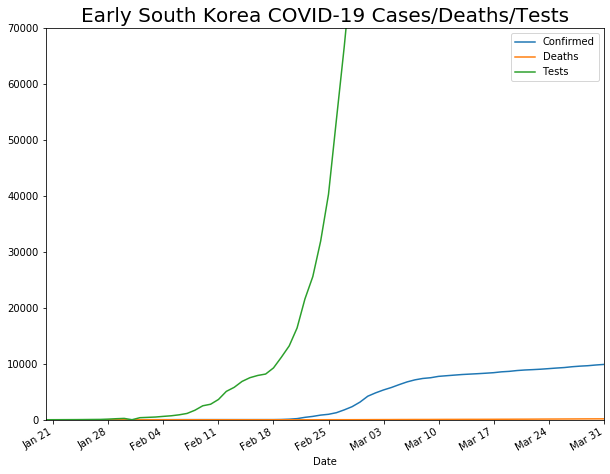

In [243]:
fig, ax = plt.subplots(figsize=(10, 8))

kor_cov19_plot_df.plot(
    ax=ax,
    #x='datetime',
    y=['Confirm_Tot', 'Death_Tot', 'Test_Tot'],
    xlim=('2020-01-20', '2020-03-31'),
    ylim=(0, 70000),
    figsize=(10, 8),
);

# x-axis label
plt.xlabel('Date')

# Rename legend
ax.legend(['Confirmed', 'Deaths', 'Tests'])

# set ticks every month
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.title('Early South Korea COVID-19 Cases/Deaths/Tests', fontdict={'size':20});

### South Korea Confirmed Cases Map - `kor_cov19_province_now_gdf`

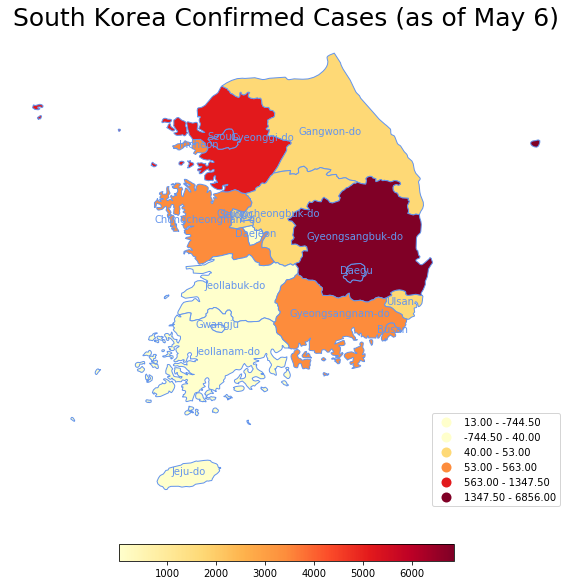

In [256]:
fig, ax = plt.subplots(figsize=(10,15))

# Normalize the Legend Color and create the legend bar
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
vmin, vmax = kor_cov19_province_now_gdf.Confirm_Tot.min(), kor_cov19_province_plot_gdf.Confirm_Tot.max()
legend_bar = plt.cm.ScalarMappable(
     norm=plt.Normalize(vmin=vmin, vmax=vmax), 
     cmap='YlOrRd')

# Plot
kor_cov19_province_now_gdf.plot(
    ax=ax,
    column='Confirm_Tot',
    cmap='YlOrRd',
    #markersize=2,
    edgecolor='cornflowerblue',
    legend=True,
    scheme='BoxPlot', # or Quantile,
    legend_kwds={'loc': 'lower right'},
)

# Title  
ax.set_title('South Korea Confirmed Cases (as of May 6)', fontdict={'size':25});

# Add the Color Legend Bar
# https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
fig.colorbar(legend_bar, ax=ax, orientation='horizontal', fraction=0.05, pad=0.04, shrink=0.6)

# Customizing legend values
# leg = ax.get_legend()
# leg.get_texts()[0].('New label 1')
# leg.get_texts()[1].set_text('New label 2')

# Displaying each State Postcode
for idx, row in kor_cov19_province_now_gdf.iterrows():
    plt.annotate(s=row['Province'], xy=row['coords'],
                 horizontalalignment='center',
                 #font.family='serif',
                 color='cornflowerblue',
                 #alpha=0.9,
                 #bbox={'facecolor':'white', 'alpha':0.5, 'pad':1, 'edgecolor':'lightyellow'}
                )

# Turn off the box and the axes label
ax.axis(False)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Crop the map to an appropriate size (via coordinate)
# ax.set_xlim(-4700000, 3000000)
# ax.set_ylim(-2500000, 4200000);

### South Korea Confirmed Cases History Map -  `kor_cov19_province_plot_gdf`